In [105]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [83]:
def first_look(df: pd.DataFrame, column: object):
    '''
    Функция для визуализации распределения количественных признаков
    '''
    printmd('### ' + str(column))
    if column in list(descriptions.keys()):
        printmd(descriptions[column])
    if df.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.countplot(df.loc[:, column], ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")
    else:
        # Prepare plot data frame
        plot_df = pd.DataFrame({'Распределение': df[column]})
        low, high = IQR_outlier(df, column, verbose=False)
        plot_df['Распределение в границах выбросов'] = df.loc[df.loc[:,column].between(low, high)][column]
        # Draw plot
        fig, ax = plt.subplots(figsize=(7 * plot_df.shape[1], 4))
        plot_df.hist(ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")
        

def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool=True) -> tuple:
    '''
    Функция для отображения границ межквартильного размаха
    '''
    printmd('### ' + str(column))
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [5]:
# добавим колонку default в тестовый датасет
test_df['default'] = 0
# добавим колонку-флажок, чтобы различать датасеты
train_df['flag'] = 1
test_df['flag'] = 0
# соединим датасеты в один
data = test_df.append(train_df, sort=False).reset_index(drop=True)
data.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,flag
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [60]:
descriptions = {
    "client_id": "идентификатор клиента",
    "education": "уровень образования",
    "sex": "пол заемщика",
    "age": "возраст заемщика",
    "car": "флаг наличия автомобиля",
    "car_type": "флаг автомобиля иномарки",
    "decline_app_cnt": "количество отказанных прошлых заявок",
    "good_work": "флаг наличия “хорошей” работы",
    "bki_request_cnt": "количество запросов в БКИ",
    "home_address": "категоризатор домашнего адреса",
    "work_address": "категоризатор рабочего адреса",
    "income": "доход заемщика",
    "foreign_passport": "наличие загранпаспорта",
    "sna": "связь заемщика с клиентами банка",
    "first_time": "давность наличия информации о заемщике",
    "score_bki": "скоринговый балл по данным из БКИ",
    "region_rating": "рейтинг региона",
    "app_date": "дата подачи заявки",
    "default": "флаг дефолта по кредиту"
}

# Типы переменных
- Числовые переменные: age, decline_app_cnt, income, bki_request_cnt, score_bki, region_rating
- Категориальные переменные: education, home_address, work_address, app_date, sna, first_time
- Переменные типа boolean: sex, car, car_type, good_work, foreign_passport

# Обработка проусков
Единственная колонка, содержащая пропуски - education.
Посмотрим на распределение данного признака:

<AxesSubplot:>

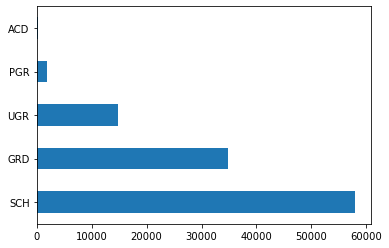

In [7]:
data['education'].value_counts().plot.barh()

In [8]:
# Заполним пропуски наиболее часто встречающимся значением
data['education'].fillna('SCH', inplace=True)

# Наивная модель

In [9]:
#бинарные признаки
bin_cols=['sex','car','car_type','good_work','foreign_passport']

#категориальные признаки
cat_cols=['education','home_address','work_address','app_date','sna', 'first_time'] 

#количественные признаки
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating']

In [10]:
#Применяем LabelEncoder к boolean-переменным
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
     
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,flag
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


In [11]:
# Заменим названия уровней образования числами
data['education'] = data['education'].replace(['SCH', 'UGR', 'GRD', 'PGR', 'ACD'], [0, 1, 2, 3, 4])

In [12]:
# пропустим ненужные колонки в данных из тренировочного датасета  
train = data.copy().query('flag == 1').drop(['client_id', 'app_date','flag'], axis=1)
X = train.drop(['default'], axis = 1)
y = train['default']

In [17]:
# Разобьем данные на train и test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

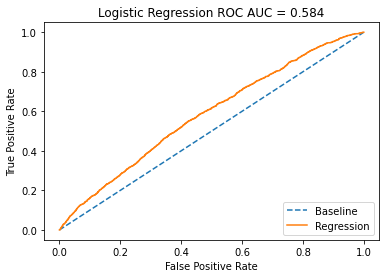

In [18]:
# Результаты наивной модели
model = LogisticRegression()
model.fit(X_train, Y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# EDA

Посмотрим на зависимость дефолта от количественных признаков:

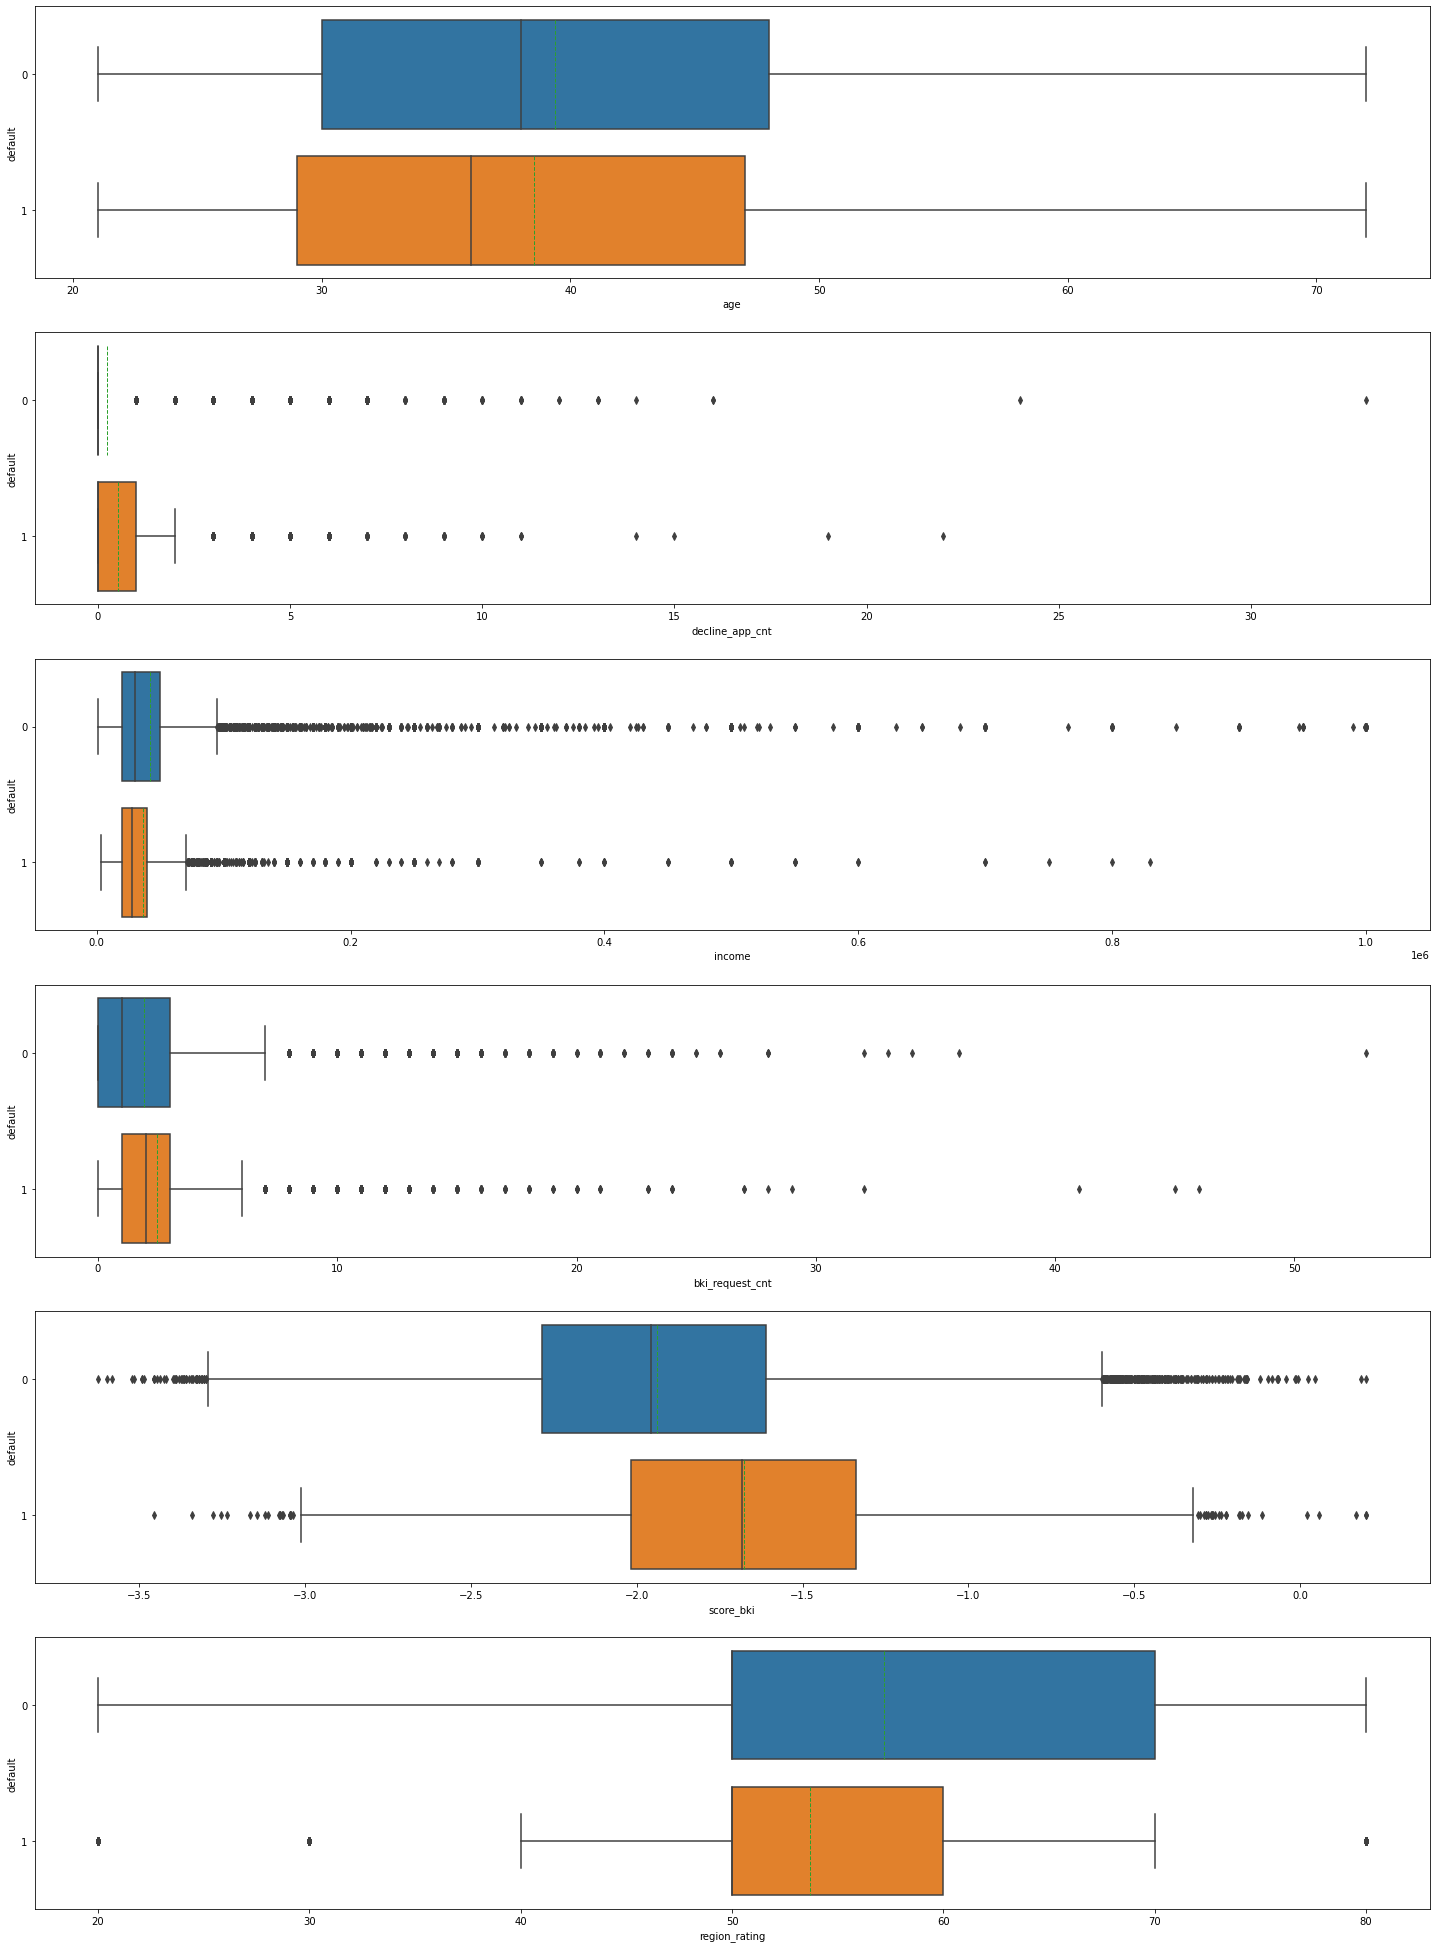

In [79]:
fig, axes = plt.subplots(6, 1, figsize=(25,35))
for i, col in enumerate(num_cols):
    sns.boxplot(x=data.query('flag == 1')[col],
                y=data.query('flag == 1')['default'],
                ax=axes.flat[i],
                showmeans=True,
                meanline=True,
                orient='h')

### Заключение
Заемщики, не возвращающие деньги банку:
- В среднем младше
- Имеют большее количество отклоненных заявок
- Имеют более низкий доход
- Имеют большее количество запросов в БКИ
- Проживают в регионах с более низким рейтингом

Посмотрим на распределение количественных признаков:

### age

возраст заемщика

<ipython-input-77-7f037204e7be>:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_df.hist(ax=ax)


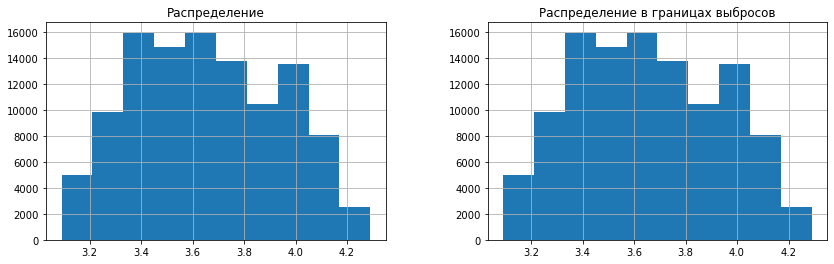

Процент пропусков:  0.0 %
25-й перцентиль: 3.4339872044851463 75-й перцентиль: 3.8918202981106265, IQR: 0.4578330936254802,  Границы выбросов: [2.7472375640469258, 4.5785699385488465].


### decline_app_cnt

количество отказанных прошлых заявок

<ipython-input-77-7f037204e7be>:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_df.hist(ax=ax)


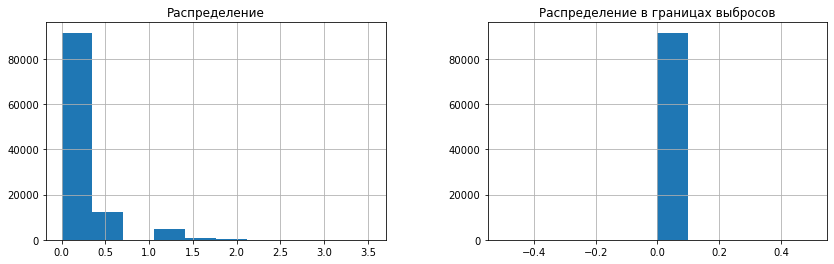

Процент пропусков:  0.0 %
25-й перцентиль: 0.0 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


### income

доход заемщика

<ipython-input-77-7f037204e7be>:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_df.hist(ax=ax)


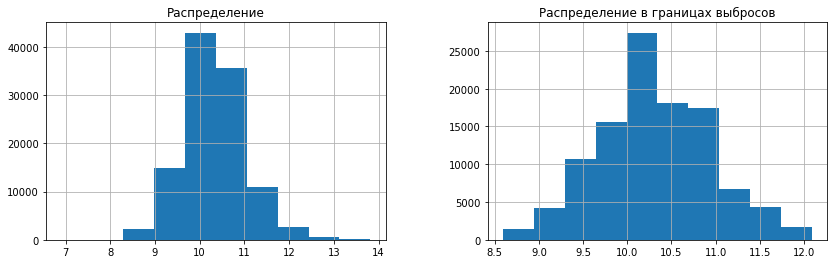

Процент пропусков:  0.0 %
25-й перцентиль: 9.90353755128617 75-й перцентиль: 10.778977123006351, IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].


### bki_request_cnt

количество запросов в БКИ

<ipython-input-77-7f037204e7be>:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_df.hist(ax=ax)


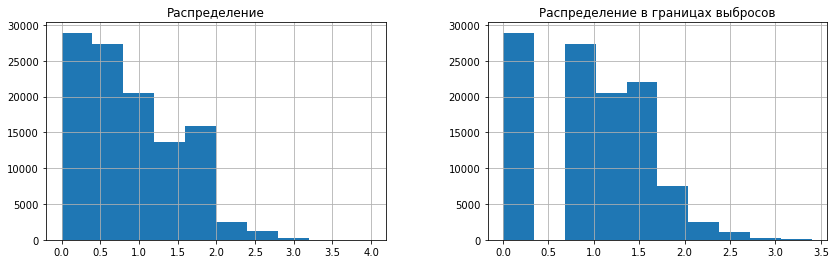

Процент пропусков:  0.0 %
25-й перцентиль: 0.0 75-й перцентиль: 1.3862943611198906, IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].


### score_bki

скоринговый балл по данным из БКИ

<ipython-input-77-7f037204e7be>:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_df.hist(ax=ax)


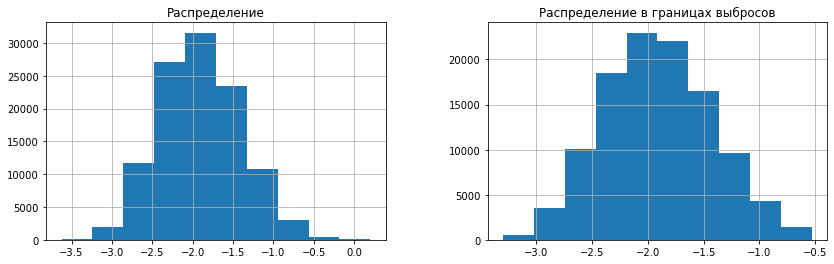

Процент пропусков:  0.0 %
25-й перцентиль: -2.2604336700000003 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].


### region_rating

рейтинг региона

<ipython-input-77-7f037204e7be>:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_df.hist(ax=ax)


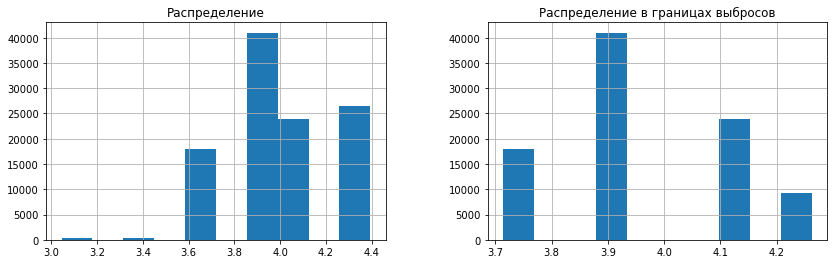

Процент пропусков:  0.0 %
25-й перцентиль: 3.9318256327243257 75-й перцентиль: 4.110873864173311, IQR: 0.17904823144898563,  Границы выбросов: [3.663253285550847, 4.37944621134679].


In [81]:
for col in num_cols:
    first_look(data, col)
    IQR_outlier(data, col)

### Заключение
Во всех колонках кроме возраста заемщика имеются выбросы. Распределение score_bki напоминает нормальное. Распределения признаков age, decline_app_cnt, income, bki_request_cnt, regional_rating имеют растянутый правый "хвост" => попробуем нормализацию логарифмированием:

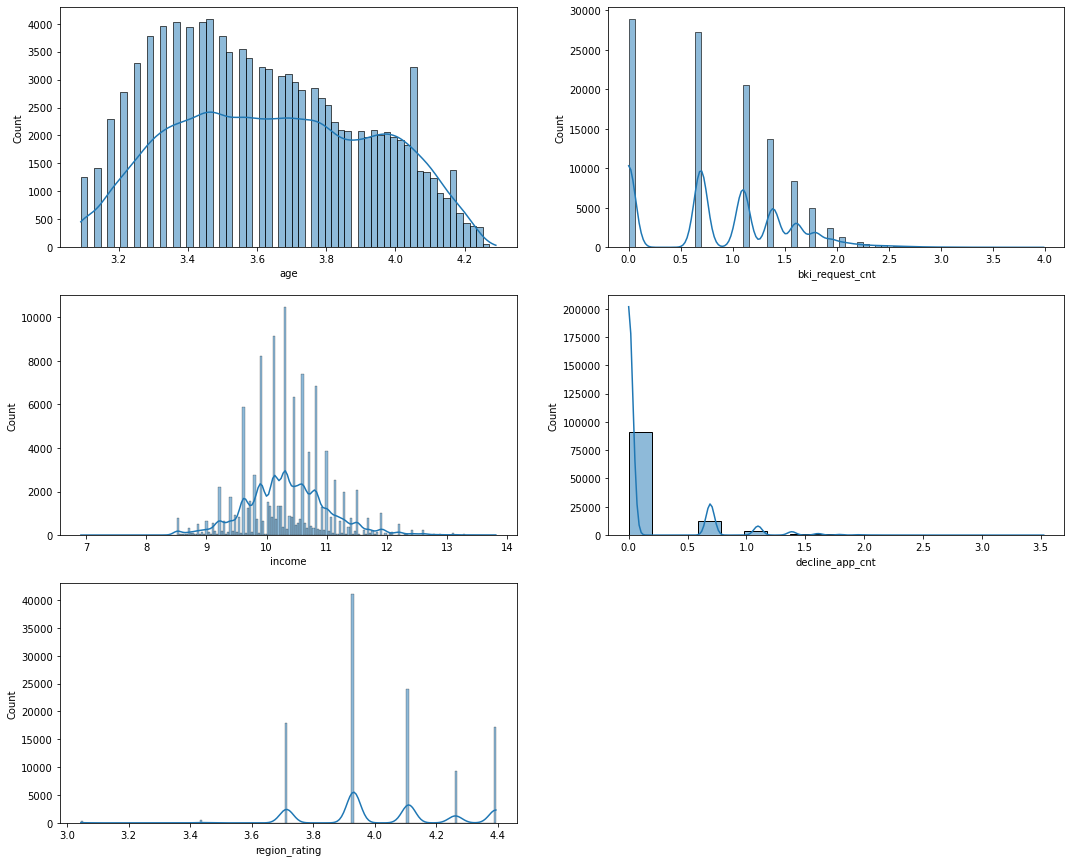

In [80]:
tail_col = ['age', 'bki_request_cnt', 'income', 'decline_app_cnt', 'region_rating']
for col in tail_col:
    data[col] = np.log(data[col]+1)
    
# Проверим результаты
fig=plt.figure(figsize=(18, 15))
columns = 2
rows = 3
for i,col in enumerate(tail_col):
    fig.add_subplot(rows, columns, i+1)
    sns.histplot(data[col], kde=True)

### Новые переменные
Создадим новые переменные на основании количественных, отражающие принадлежность клиента к "среднему" или его отклонение в большую или меньшую сторону, для этого найдем заново межквартильный размах:

In [84]:
for col in num_cols:
    IQR_outlier(data, col)

### age

25-й перцентиль: 3.4339872044851463 75-й перцентиль: 3.8918202981106265, IQR: 0.4578330936254802,  Границы выбросов: [2.7472375640469258, 4.5785699385488465].


### decline_app_cnt

25-й перцентиль: 0.0 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


### income

25-й перцентиль: 9.90353755128617 75-й перцентиль: 10.778977123006351, IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].


### bki_request_cnt

25-й перцентиль: 0.0 75-й перцентиль: 1.3862943611198906, IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].


### score_bki

25-й перцентиль: -2.2604336700000003 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].


### region_rating

25-й перцентиль: 3.9318256327243257 75-й перцентиль: 4.110873864173311, IQR: 0.17904823144898563,  Границы выбросов: [3.663253285550847, 4.37944621134679].


In [86]:
age_bins = [0, 3.43, 3.89, np.inf]
age_labels = [0, 1, 2]
data['age_cat'] = pd.cut(data['age'], bins = age_bins, labels = age_labels)

In [87]:
income_bins = [0, 9.9, 10.78, np.inf]
income_labels = [0, 1, 2]
data['income_cat'] = pd.cut(data['income'], bins = income_bins, labels = income_labels)

In [89]:
region_bins = [0, 3.93, 4.11, np.inf]
region_labels = [0, 1, 2]
data['region_rating_cat'] = pd.cut(data['region_rating'], bins = region_bins, labels = region_labels)

# Категориальные переменные

In [90]:
# преобразуем дату в фотрмат datetime
data['app_date'] = pd.to_datetime(data['app_date'])

In [91]:
# проверим за какие годы и месяцы имеются данные в датасете
print(f"{data['app_date'].dt.year.unique()}\n{data['app_date'].dt.month_name().unique()}\
    \n{sorted(data['app_date'].dt.day.unique())}")

[2014]
['March' 'January' 'February' 'April']    
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


В датасете присутствуют данные только за 4 месяца, поэтому делать переменные на основании месяца подачи не имеет смысла

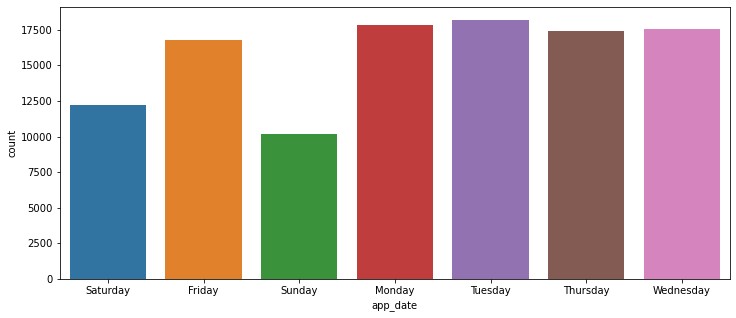

In [92]:
# проверим, сколько заявок было подано по дням недели
fig = plt.subplots(figsize=(12, 5))
sns.countplot(x=data['app_date'].dt.day_name());

На выходных заявки подают реже. Можно добавить признак - день недели, в который была подана заявка

In [94]:
days = dict(zip(data['app_date'].dt.day_name().sort_values().unique(), range(len(data['app_date'].dt.day_name())+1)))
data['app_day'] = data['app_date'].dt.day_name().map(days)

In [98]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,flag,age_cat,income_cat,region_rating_cat,app_day
0,74835,2014-03-22,2,1,3.401197,1,1,0.000000,0,-2.271884,...,10.819798,1,4,0,0,0,0,2,1,2
1,17527,2014-01-24,0,0,3.688879,0,0,1.791759,0,-1.504999,...,8.517393,4,3,0,0,0,1,0,1,0
2,75683,2014-03-23,1,1,3.931826,1,1,0.000000,0,-1.691339,...,10.308986,1,3,1,0,0,2,1,1,3
3,26883,2014-02-03,0,1,4.043051,0,0,0.000000,0,-2.374182,...,9.741027,1,3,0,0,0,2,0,0,1
4,28862,2014-02-04,2,0,3.663562,0,0,0.000000,0,-2.487502,...,11.695255,1,3,0,0,0,1,2,2,5


# Корреляция признаков

<AxesSubplot:>

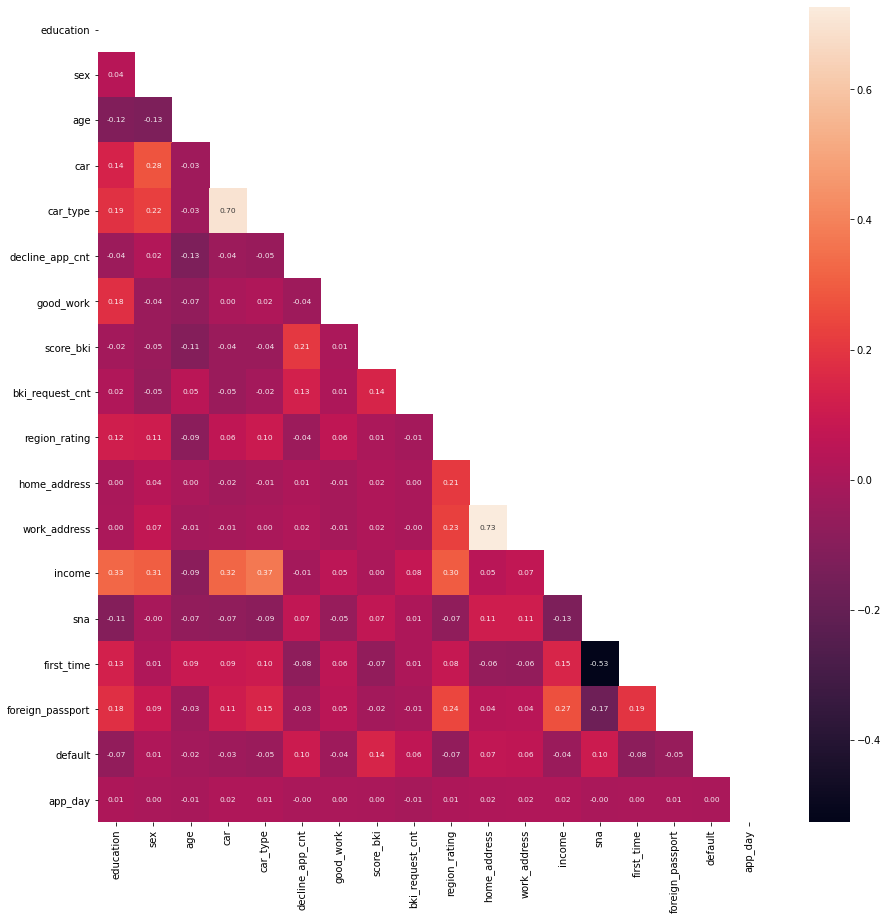

In [97]:
fig, ax = plt.subplots(figsize=(15,15))      
matrix = np.triu(data.drop(['client_id', 'app_date','flag'], axis=1).corr())
sns.heatmap(data.drop(['client_id', 'app_date','flag'], axis=1).corr(), \
            annot=True, mask=matrix, fmt = '.2f', annot_kws={"size": 7.5, "alpha" : 0.9})

In [101]:
# бинарные признаки
bin_cols=['sex', 'car', 'car_type', 'good_work','foreign_passport']

#категориальные признаки
cat_cols=['education','sna', 'first_time', 'age_cat', 'income_cat',
          'region_rating_cat', 'app_day', 'home_address', 'work_address'] 

#количественные признаки
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating']

<AxesSubplot:>

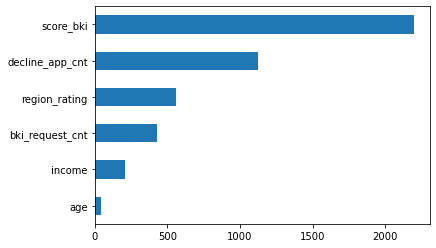

In [102]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

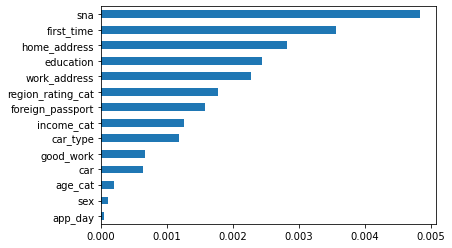

In [103]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Признаков получилось не очень много, очень сильной корреляционной связи между ними не наблюдается, попробуем ничего не удалять

In [115]:
data_dumm = pd.get_dummies(data, columns = cat_cols)

# Обучаем модель

C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


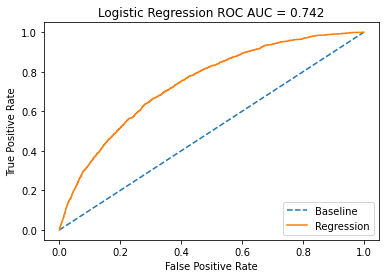

In [116]:
train = data_dumm.copy().query('flag == 1').drop(['client_id', 'app_date','flag'], axis=1)
X = train.drop(['default'], axis = 1)
y = train['default']
# split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [118]:
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced').fit(X_train, Y_train)
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

# Настройка гиперпараметров

In [107]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, Y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, Y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", l

C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

Лучшее Penalty: l2
Лучшее C: 1.0


C:\Users\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Долго пыталась разобраться, что теперь делать с этой информацией, но так и не смогла :(

# Submission

In [122]:
prediction = data_dumm.copy().query('flag == 0')

# убираем лишнее
test = prediction.drop(['client_id', 'app_date','flag', 'default'], axis=1)

# создаем итоговый файл
y_pred_final = model.predict_proba(test)[:, 1]
submission = pd.concat([prediction.client_id,pd.Series(y_pred_final,name='default')],axis=1)
submission.to_csv('submission.csv', index=False)
display(submission)

,client_id,default
0,74835,0.203722
1,17527,0.764718
2,75683,0.318110
3,26883,0.389696
4,28862,0.137405
...,...,...
36344,83775,0.801433
36345,106254,0.135065
36346,81852,0.799433
36347,1971,0.587067
